## Overview
The goal of this notebook is to analyze the ill-posedness of a source inversion problem based on the one dimensional heat equation.

#### Forward Model
Here we will consider the one dimensional heat equation with unit thermal conductivity.  This equation takes the 
form
$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial t^2} + f(x),
$$
where $u(x)$ is the temperature and $f(x)$ is a heat flux term.  For this example, we consider the domain $x\in[0,1]$ and assume there is no external source term, so $f(x)=0$.  At the boundaries, we assume Dirichlet conditions $u(0)=0$ and $u(1)=0$. 

After discretizing in space, we are left with an expression of the form
$$
\frac{\partial u}{\partial t} = Au,
$$
where $A$ is a sparse matrix defining a second order finite difference operation.  This system has an analytical solution of the form 
$$
u(t) = J(t) u_0,
$$
where $J(t) = \exp(At)$ and $u_0$ is the initial condition.

The class `HeatEquation1d` defines a finite difference discretization of this equation (second order finite difference in space and Crank-Nicholson in time).   This class has two functions that will be useful to us, the `Solve` function, which solves for $u$ until some final time $T$ and the `Jacobian` function, which returns $J(t)$, the sensitivity of $u(T)$ with respect to $u_0$.  

#### Inverse Problem
This notebook considers the inverse problem that arises when trying to estimate the initial temperature $u_0=u(0)$ given observations of $u(t)$ for some later time $t$.



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../CommonTools")

from HeatEquation import HeatEquation1d


## Set up the 1d heat equation solver

In [2]:
# The number of nodes in the spatial finite difference discretization
Nx = 100

# The time step used by the Crank-Nicholson integrator
dt = 1e-4

# The final time we wish to solve for.  This is also the "observation time"
endTime = 1e-1

# Set up the Heat equation solver
heat = HeatEquation1d(Nx, dt)

# Get the locations of the finite difference nodes
nodeLocs = heat.NodeLocations()

print(nodeLocs)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

As an initial condition, we use a step function given by
$$
u_0 = \left\{\begin{array}{ll} 1 & x\in[x_L, x_U] \\ 0 & \text{Otherwise}\end{array} \right.
$$

In [13]:
# Create an initial condition that is a step in the middle of the domain
stepLeft = 0.4
stepRight = 0.6
u0 = np.zeros((Nx,))
u0 = np.exp(-20*(nodeLocs-0.5)**2)
#u0[(nodeLocs>=stepLeft)&(nodeLocs<=stepRight)] = 1.0

# Solve for the temperature at every timestep between 0 and endTime
u = heat.Solve(u0, endTime)

## Plot the solution

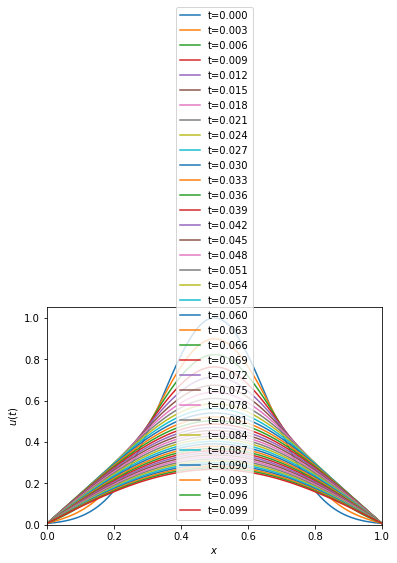

In [14]:
# Number of time steps to skip between plotting.  Just so that the figure doesn't get too busy.
thinBy = 30 

Nt = u.shape[1]
for i in range(0,Nt,thinBy):
    plt.plot(nodeLocs,u[:,i], label='t=%0.3f'%(i*dt));

plt.legend()
plt.ylim((0,1.05))
plt.xlim((0,1))
plt.xlabel('$x$')
plt.ylabel('$u(t)$');

## Look at the sensitivity of the solution with respect to initial conditions

> **Question:** How does the sensitivity change with time? Can you think of any physical reason why?

Row $i$ of the Jacobian matrix contains the derivatives of $u(x_i,t)$ with respect to the initial conditions $u(x)$.   Therefore,
$$
J_{ij} = \frac{\partial u(x_i,t)}{\partial u(x_j,0)}.
$$

(100, 100)
100


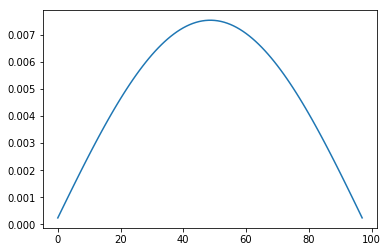

In [15]:
J = heat.Jacobian(endTime)
print(J.shape)
print(Nx)

plt.plot(J[int(Nx/2),1:-1])

## Spectrum of misfit Hessian

> **Question 1:** What does the misfit function look like?

> **Question 2:** How do the eigenvalues of the Hessian of the misfit function decay?  How does this depend on time?

*Hint: The form of the misfit function is identical to regression.*

$$
y = u(t)
$$
$$
m = u_0
$$
$$
A = J(t)
$$

$$
\rho(m) = \frac{1}{2}(Am- y)^T(Am-y)
$$

Gradient:
$$
\nabla_m \rho(m) = (Am-y)^TA
$$

Hessian:
$$
\nabla^2_m \rho(m) = A^T A
$$

Choose $y$ to be the solution using the previous initial condition at `endTime`:

`
y = u[:,-1]
`
`
A = heat.Jacaobian(endTime)
`

To tranpose a matrix with numpy, `At = A.T`

Potentially useful functions:
- [np.linalg.svd](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)
- [np.linalg.eigh](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html)
- [np.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)

In [16]:
A = heat.Jacobian(endTime)
y = u[:,-1] # <- The solution for all x and endTime

In [17]:
hess = np.dot(A.T, A)

In [18]:
lam,v = np.linalg.eigh(hess)
print(u.shape)
print(v.shape)

(100, 1000)
(100, 100)


Text(0.5, 0, 'k')

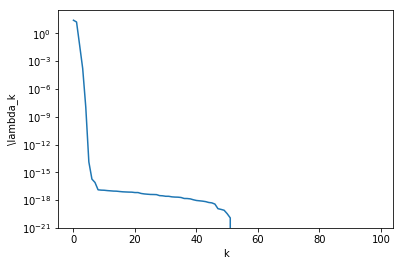

In [19]:
plt.semilogy(np.flip(lam))
plt.ylabel('\lambda_k')
plt.xlabel('k')

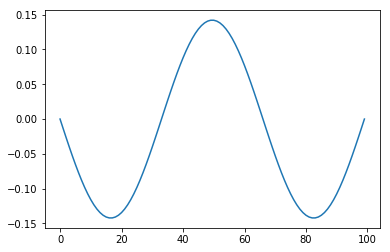

In [20]:
plt.plot(v[:,-5])

In [21]:
sol = np.linalg.pinv(A)@y

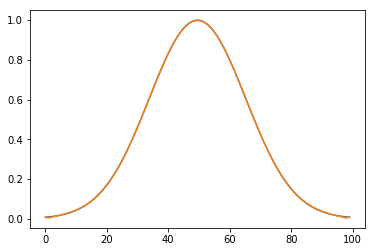

In [22]:
plt.plot(u[:,0], label='Truth')
plt.plot(sol, label='Unregularized Solution')